## Libraries

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier ## change "sparse" to "sparse_output" in the supervised.py file

# metrics
from sklearn.metrics import(
    recall_score, accuracy_score, f1_score, precision_score, 
    classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, auc)

#widgets and display
import ipywidgets as widgets
from IPython.display import display

#SHAP explainer
import shap

#utilities
import pickle
import os
from tqdm import tqdm

## Load data set

In [3]:
from src.load_data import load_data
file_path = "../data/raw/flight_df (2).csv"
df = load_data(file_path)
df.head()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,26,3,2062,2,3,3,3,2,2,2,...,3,3,3,2,0,0,0,1,1,0
1,52,3,680,5,5,5,5,3,4,4,...,4,4,4,4,18,2,0,1,1,1
2,28,1,188,3,5,3,4,3,3,3,...,4,4,5,3,0,0,1,1,0,0
3,54,3,453,3,5,5,5,3,4,4,...,3,4,3,1,91,80,0,1,1,0
4,40,1,775,4,3,3,3,4,4,4,...,3,3,3,4,0,0,1,1,1,0


## Model validation 

In [7]:
#Define target 
y=df['satisfied']
X=df.drop(columns='satisfied')

In [8]:
#split the data into train and tests
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.20 , random_state=42)

In [9]:
from src.preprocessing_pipeline import create_preprocessing_pipeline

#create the preprocessors
preprocessor = create_preprocessing_pipeline()

In [10]:
from src.data_preprocessing import preprocess_and_rebalance_data

#preprocess and rebalance teh data
X_train_balanced, X_test_transformed, y_train_balanced = preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train)

In [11]:
X_train_balanced_df = pd.DataFrame(X_train_balanced)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

## Machine Learning

#### LazyClassifier


In [32]:
from sklearn.pipeline import Pipeline
# Function to create the ML pipeline
def train_and_predict_model(X_train, y_train, X_test, preprocessor, model):
    
    # Combine the preprocessing pipeline and model into a single pipeline
    model_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model),
    ])
    
    # Fit the pipeline on the training data
    model_pipe.fit(X_train, y_train)
    
    # Save the predictions for both train and test sets
    train_preds = model_pipe.predict(X_train)
    test_preds = model_pipe.predict(X_test)
    
    return train_preds, test_preds

In [33]:
# Import library
import lightgbm as lgb
# Instantiate the LGBMClassifier
lgbm_model = lgb.LGBMClassifier(verbose=0, random_state=42)
# Create and save predictions
train_preds, test_preds = train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, lgbm_model)

In [39]:
# Function to predict and compare the models
def evaluate_models(model, X_train, y_train, X_test, y_test):
    
    # Create prediction on the training set
    train_preds = np.rint(model.predict(X_train))
    test_preds = np.rint(model.predict(X_test))
    
    # Classification report on train set
    train_report = classification_report(y_train, train_preds)
    test_report = classification_report(y_test, test_preds)
    
    # Confusion matrix for the training set
    cm_train = confusion_matrix(y_train, train_preds)
    cm_test = confusion_matrix(y_test, test_preds)
    
    # Plot train summary and confusion matrix side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].text(0.01, 0.05, str(train_report), {'fontsize': 12}, fontproperties="monospace")
    axes[0].axis('off')
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axes[1], cmap='Blues')
    axes[1].set_title("Confusion Matrix - Training Set")
    
    # Plot train summary and confusion matrix side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].text(0.01, 0.05, str(test_report), {'fontsize': 12}, fontproperties="monospace")
    axes[0].axis('off')
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(ax=axes[1], cmap='Blues')
    axes[1].set_title("Confusion Matrix - Testing Set")
    
    plt.show()
    
    return train_report, test_report

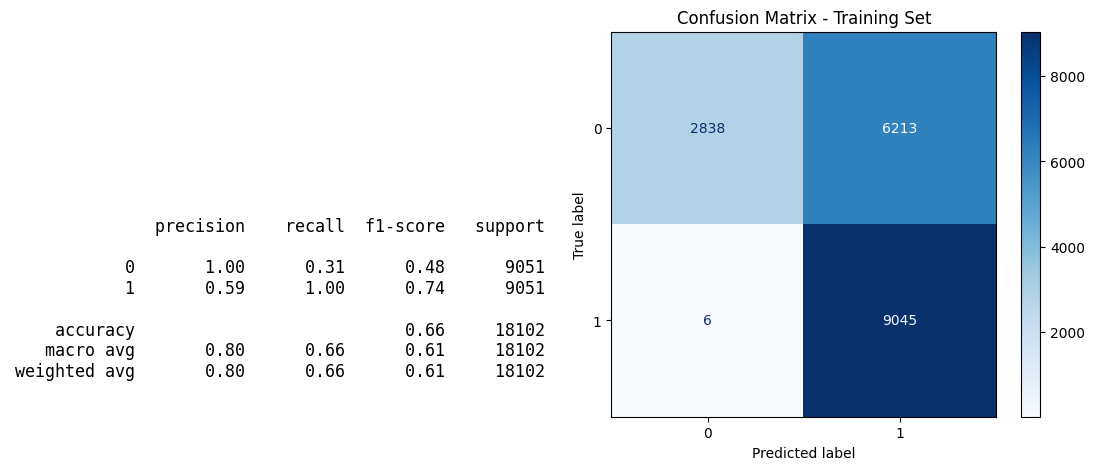

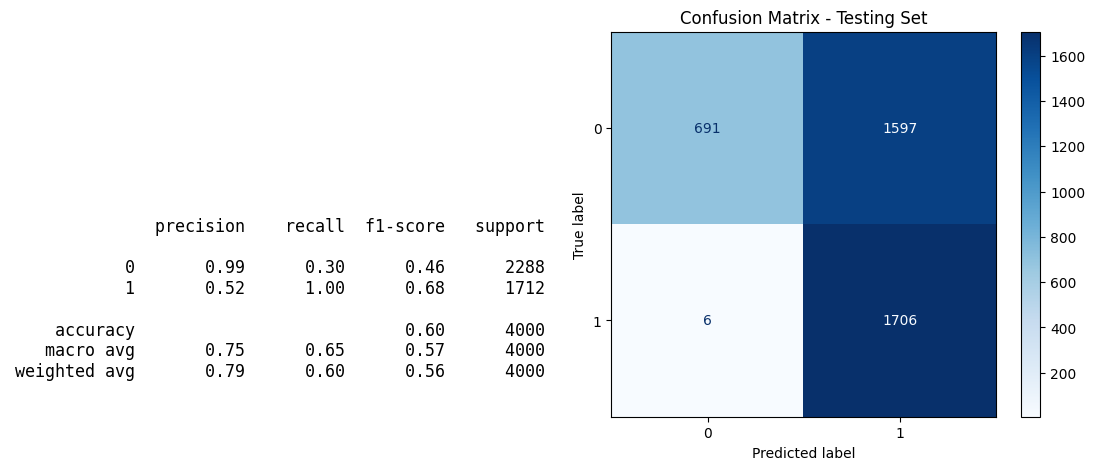

In [40]:
train_report, test_report = evaluate_models(lgbm_model, X_train_balanced, y_train_balanced, X_test_transformed, y_test)

In [41]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()

train_preds, test_preds = train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_transformed_df, preprocessor, dec_tree)

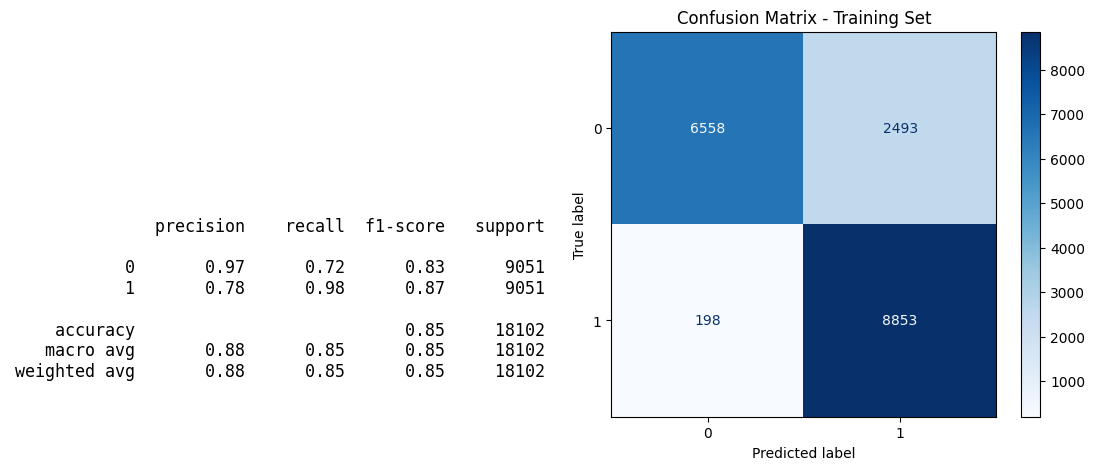

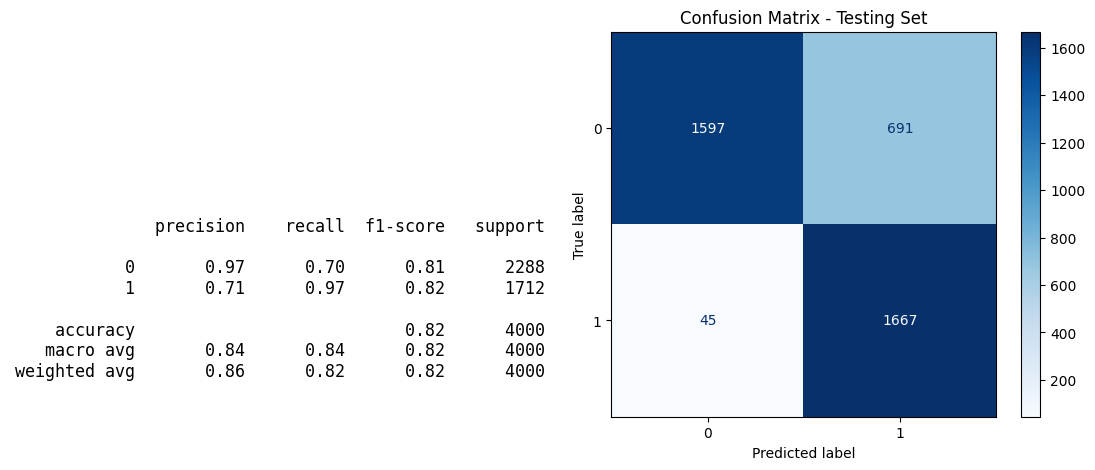

In [42]:
train_report, test_report = evaluate_models(dec_tree, X_train_balanced, y_train_balanced, X_test_transformed, y_test)

## Feature Importance

In [48]:
np.random.seed(42)

#fuinction to train the model
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

#fucntion to get feature importance
def get_feature_importance(model, fearture_names):
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_names, 
         'importance': importance,
         }).sort_values(by='importance', ascending=False)
    
    return feature_importance

#plot the features with a color palette
def plot_feature_importance(feature_importance, title):
    plt.figure(figsize=(10,5))

    #use a color palette
    sns.barplot(
        x='importance', 
        y='feature', 
        data=feature_importance,
        palette='viridis',
        hue='feature'
        )
    
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show 

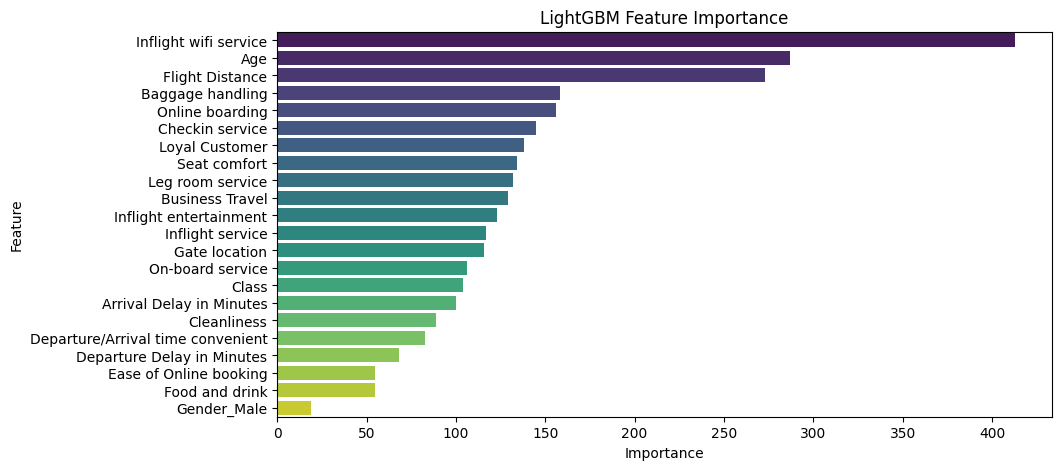

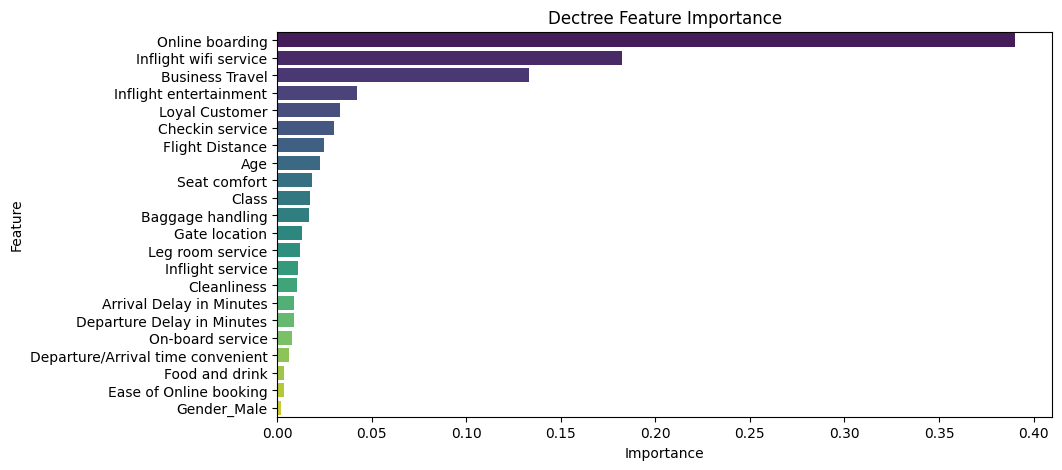

In [50]:
#get feature names
feature_names = X_train.columns

trained_lgbm_model = train_model(lgbm_model, X_train_balanced, y_train_balanced)

#get and plit the feature importance of the trained LGBM model
lgbm_feature_importance = get_feature_importance(trained_lgbm_model, feature_names)
plot_feature_importance(lgbm_feature_importance, 'LightGBM Feature Importance')


trained_dec_tree_model = train_model(dec_tree, X_train_balanced, y_train_balanced)
dec_tree_feature_importance = get_feature_importance(trained_dec_tree_model, feature_names)
plot_feature_importance(dec_tree_feature_importance, 'Dectree Feature Importance')

#### Decision Tree Feature Importance:
1. **Online boarding** is by far the most significant feature.
2. **Inflight wifi service** and **Business Travel** are also highly important.
3. Features like **Inflight entertainment**, **Loyal Customer**, and **Checkin service** have moderate importance.
4. Lower importance is given to **Ease of Online booking** and **Gender_Male**.

#### LightGBM Feature Importance:
1. **Inflight wifi service** is the most critical feature.
2. **Age** and **Flight Distance** also rank very high.
3. **Baggage handling**, **Online boarding**, and **Checkin service** show moderate importance.
4. Features like **Ease of Online booking** and **Gender_Male** are of lower importance.

### 10 Most Common Features:

1. Inflight wifi service
2. Online boarding
3. Age
4. Flight Distance
5. Baggage handling
6. Checkin service
7. Loyal Customer
8. Seat comfort
9. Business Travel
10. Inflight entertainment

In [27]:
def initialize_lazy_classifier():
    lazy_class = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None) #verbose = updates on the model 
    return lazy_class

In [28]:
def fit_and_evaluate_lc(lazy_class, X_train, X_test, y_train, y_test):
    models, predictions = lazy_class.fit(X_train, X_test, y_train, y_test)
    return models, predictions

In [29]:
lazy_class = initialize_lazy_classifier()

#fit and evaliate the lazy classifier
models, predictions = fit_and_evaluate_lc(lazy_class, X_train_balanced, X_test_transformed, y_train_balanced, y_test)

#display the results
print(models)

 97%|█████████▋| 30/31 [01:30<00:01,  1.44s/it]

[LightGBM] [Info] Number of positive: 9051, number of negative: 9051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4676
[LightGBM] [Info] Number of data points in the train set: 18102, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 31/31 [01:30<00:00,  2.92s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.96               0.95     0.95      0.96   
XGBClassifier                      0.96               0.95     0.95      0.96   
RandomForestClassifier             0.95               0.95     0.95      0.95   
ExtraTreesClassifier               0.95               0.95     0.95      0.95   
BaggingClassifier                  0.95               0.94     0.94      0.95   
SVC                                0.94               0.94     0.94      0.94   
DecisionTreeClassifier             0.94               0.94     0.94      0.94   
AdaBoostClassifier                 0.93               0.93     0.93      0.93   
KNeighborsClassifier               0.92               0.91     0.91      0.92   
NuSVC                              0.91               0.90     0.90      0.91   
LabelPropagation            